In [ ]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 16:20:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#########################################################################
## MONTAR DRIVE
#########################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#########################################################################
## CONFIGURAR WANDB
#########################################################################
!pip install wandb
!wandb login

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 181 kB 67.9 MB/s 
     |████████████████████████████████| 145 kB 49.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f85afddee9e41c85bdf94520be74a94c03e2bef8c517be3cb215b91fd09f9722
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#########################################################################
## CARGAR LAS LIBRERÍAS NECESARIAS
#########################################################################
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import mnist
import numpy as np

from random import shuffle,seed

import seaborn as sns

import keras
from tensorflow.keras import layers

from keras import metrics
import keras.utils

from skimage.transform import resize

In [ ]:
#########################################################################
## INICIAR WANDB
#########################################################################
import wandb
from wandb.keras import WandbCallback

In [ ]:
# Variables globales
num_imagenes=250 
batch_size=8
epochs = 75
latent_dim=128

In [ ]:
################################################################################################################
## FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS
###############################################################################################################

# La base de datos MNIST contiene 60000 ejemplos en el conjunto de entrenamiento y 10000 en el conjunto de prueba
# Las imagenes tienen un tamaño 28x28 que redimensionaremos a 28x28x1
def load_data(): 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
   
    #Cambio el tamaño de las imágenes de 28x28 a 28x28x1
    x_train= x_train.reshape((60000, 28, 28, 1))
    x_test= x_test.reshape((10000, 28, 28, 1))
   
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
   
    #Añadir algo de ruido en el conjunto de prueba
    x_test = np.random.normal(x_test) 
   
    #Normalizamos a escala [0,1] 
    x_train,x_test= x_train / 255,x_test / 255

    return (x_train, y_train), (x_test, y_test)

#Cargamos toda la base de datos MNIST
(x_train, y_train), (x_test, y_test) = load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Barajamos el conjunto de datos para no tener clases contiguas y nos quedamos con num_imagenes imágenes

# Declaramos una semilla
seed(123456)

# Guardamos índices
ind_train = list(range(len(x_train)))
ind_test = list(range(len(x_test)))

# Desordenamos los indices para quedarnos con num_imagenes imagenes aleatorias
shuffle(ind_train)
shuffle(ind_test)

# En base a los indices nos quedamos con num_imagenes imágenes
x_train            = x_train[ind_train[0:num_imagenes]]
y_train            = y_train[ind_train[0:num_imagenes]]

x_test             = x_test[ind_test[0:num_imagenes]]
y_test             = y_test[ind_test[0:num_imagenes]]

In [ ]:
################################################################################################################
## CLASE WGAN
###############################################################################################################
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    # Evaluación del Discriminador
    def evaluate_D(self):
      #Generamos las imágenes a partir del espacio latente y el generador
      batch_size = tf.shape(x_train)[0]
      random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
      generated_images = self.generator(random_latent_vectors)
      
      #Compilamos el modelo discriminador
      self.discriminator.compile(optimizer=self.d_optimizer,loss=self.d_loss_fn,metrics=['accuracy'])
      
      #Evaluación del discriminador con las imágenes reales
      loss_real, acc_real = self.discriminator.evaluate(x_test,tf.ones((batch_size, 1),dtype=tf.dtypes.float32), verbose=1)

      #Evaluación del discriminador con las imágenes falsas
      loss_fake, acc_fake = self.discriminator.evaluate(generated_images,tf.zeros((batch_size, 1),dtype=tf.dtypes.float32) , verbose=1)

      # Mostramos por pantalla un resumen 
      print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
      print('>Loss real: ')
      print(loss_real)
      print('>Loss fake: ')
      print(loss_fake)
      
    # Evaluación del Generador
    def evaluate_G(self):
      #Generamos las imágenes a partir del espacio latente y el generador
      batch_size = tf.shape(x_train)[0]
      random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
      generated_images = self.generator(random_latent_vectors)

      #Visualizamos varias imágenes generadas seleccionadas de forma aleatoria
      for i in range(9):
          random_latent_vectors = tf.random.normal(
        shape=(9, 128))
          pred = generator(random_latent_vectors )
          plt.subplot(331 + i)
          plt.axis('off')
          plt.imshow(np.squeeze(pred[0]), cmap='gray')
      plt.show()

    # Calculo de la penalización del gradiente
    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Imagen interpolada
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    #Entrenamiento
    def train_step(self, real_images):
      if isinstance(real_images, tuple):
          real_images = real_images[0]

      batch_size = tf.shape(real_images)[0]

      #ENTRENAMIENTO DEL DISCRIMINADOR: se entrena al discriminador varias veces entre cada actualización del generador.
      for i in range(self.d_steps):
          # Vector latente
          random_latent_vectors = tf.random.normal(
              shape=(batch_size, self.latent_dim)
          )
          with tf.GradientTape() as tape:
              #Generamos la imagen falsa
              fake_images = self.generator(random_latent_vectors, training=True)
              # Obtenemos los logits de la imagen falsa
              fake_logits = self.discriminator(fake_images, training=True)
              # Obtenemos los logits de la imagen real
              real_logits = self.discriminator(real_images, training=True)

              # Calculamos la pérdida del discriminador usando los logits de la imagen real y falsa
              d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
              # Calculamos la penalización del gradiente
              gp = self.gradient_penalty(batch_size, real_images, fake_images)
              # Añadimos la penalizacion del gradiente a la pérdida del discriminador
              d_loss = d_cost + gp * self.gp_weight

          # Obtenemos el gradiente w.r.t de la función de  pérdida del discriminador
          d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
          # Actualizamos los pesos del modelo DISCRIMINADOR usando el optimizador del discriminador
          self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

      # ENTRENAMIENTO DEL GENERADOR
      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
      with tf.GradientTape() as tape:
          # Generamos la imagen falsa a traves del generador
          generated_images = self.generator(random_latent_vectors, training=True)
          # Obtenemos los logits del discriminador en la imagen falsa
          gen_img_logits = self.discriminator(generated_images, training=True)
          # Calculamos la función de pérdida del generador
          g_loss = self.g_loss_fn(gen_img_logits)

      # Conseguimos el gradiente w.r.t de la pérdida del generador
      gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
      # Actualizamos los pesos del GENERATOR usando el optimizador del generador
      self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
      return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
################################################################################################################
## Función para mostrar por pantalla 9 imágenes reales, 9 imagenes reales con ruido 
## y 9 imágenes generadas por nuestro modelo generador
###############################################################################################################
def generated_images_plot(original, noised_data, generator):
    """Plot subplot of images during training."""
    print('NOISED')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(noised_data[i]), cmap='gray')
    plt.show()
    
    print('GENERATED')
    for i in range(9):
        random_latent_vectors = tf.random.normal(
      shape=(9, 128))
        pred = generator(random_latent_vectors )
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(pred[0]), cmap='gray')
    plt.show()
    print('ORIGINAL')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(original[i]), cmap='gray')
    plt.show()


In [ ]:
################################################################################
# Declaramos optimizadores y funciones de pérdida del generador-discriminador
#################################################################################
generator_optimizer = tf.keras.optimizers.Adam(
	learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

discriminator_optimizer =tf.keras.optimizers.Adam(
	learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# EXPERIMENTO 1

In [ ]:
discriminator=keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1), #Se elimina la activación sigmoidea para que la salida no este en [0,1]
    ],
    name="discriminator"

)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)               

In [ ]:
generator=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7*7*128),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 64)        0 

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 0.0001,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

# Definimos el modelo WGAN.
wgan = WGAN(discriminator=discriminator,
			generator=generator,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Entrenamiento
wgan.fit(x_train, epochs=epochs, callbacks=[WandbCallback()])

wandb.finish()
       

wandb: Currently logged in as: ugr-sail (sail-ugr). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/75
8/8 [==============================] - 20s 37ms/step - d_loss: 5.8381 - g_loss: 0.6479 - _timestamp: 1652890979.0000 - _runtime: 27.0000
Epoch 2/75
8/8 [==============================] - 0s 27ms/step - d_loss: -0.1282 - g_loss: 3.4255 - _timestamp: 1652890979.0000 - _runtime: 27.0000
Epoch 3/75
8/8 [==============================] - 0s 27ms/step - d_loss: -7.1498 - g_loss: 9.4369 - _timestamp: 1652890979.0000 - _runtime: 27.0000
Epoch 4/75
8/8 [==============================] - 0s 28ms/step - d_loss: -10.7165 - g_loss: 14.8039 - _timestamp: 1652890979.0000 - _runtime: 27.0000
Epoch 5/75
8/8 [==============================] - 0s 28ms/step - d_loss: -12.5840 - g_loss: 16.9973 - _timestamp: 1652890980.0000 - _runtime: 28.0000
Epoch 6/75
8/8 [==============================] - 0s 27ms/step - d_loss: -13.1627 - g_loss: 17.1258 - _timestamp: 1652890980.0000 - _runtime: 28.0000
Epoch 7/75
8/8 [==============================] - 0s 27ms/step - d_loss: -13.5608 - g_loss: 15.2130 - _tim

d_loss,█▅▂▁▁▂▂▃▃▃▄▄▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▃▅██▆▄▃▂▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅
d_loss,-1.29312
epoch,74
g_loss,7.37


8/8 [==============================] - 0s 3ms/step - loss: -7.3079 - accuracy: 1.0000
>Accuracy real: 0%, fake: 100%
>Loss real: 
-7.275440216064453
>Loss fake: 
-7.307855606079102


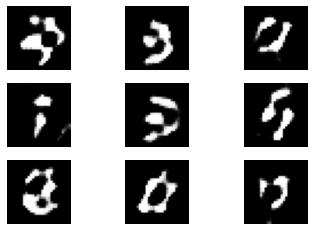

In [ ]:
#Evaluación
wgan.evaluate_D()
wgan.evaluate_G()

# EXPERIMENTO 2
Vamos a realizar la siguiente mejora para que la pérdida del generador no supere a la pérdida del discriminador y consigan igualarse.  
En el **Discriminador** vamos a hacer una **reducción del learning rate** y un **incremento del dropout**.

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3, beta_1=0.5, beta_2=0.9)
discriminator2=keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1),
    ],
    name="discriminator2"

)
discriminator2.summary()

Model: "discriminator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_1 (Dropout)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)              

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 1e-3,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

# Definimos el modelo WGAN.
wgan = WGAN(discriminator=discriminator2,
			generator=generator,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Entrenamiento
wgan.fit(x_train, epochs=epochs, callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/75
8/8 [==============================] - 4s 31ms/step - d_loss: 0.6324 - g_loss: -0.0561 - _timestamp: 1652891022.0000 - _runtime: 8.0000
Epoch 2/75
8/8 [==============================] - 0s 27ms/step - d_loss: -0.1843 - g_loss: 0.1578 - _timestamp: 1652891023.0000 - _runtime: 9.0000
Epoch 3/75
8/8 [==============================] - 0s 27ms/step - d_loss: -0.4872 - g_loss: 1.5860 - _timestamp: 1652891023.0000 - _runtime: 9.0000
Epoch 4/75
8/8 [==============================] - 0s 28ms/step - d_loss: -0.5935 - g_loss: 0.7882 - _timestamp: 1652891023.0000 - _runtime: 9.0000
Epoch 5/75
8/8 [==============================] - 0s 27ms/step - d_loss: -0.6823 - g_loss: 1.9946 - _timestamp: 1652891023.0000 - _runtime: 9.0000
Epoch 6/75
8/8 [==============================] - 0s 29ms/step - d_loss: -0.8037 - g_loss: 2.6129 - _timestamp: 1652891024.0000 - _runtime: 10.0000
Epoch 7/75
8/8 [==============================] - 0s 27ms/step - d_loss: -1.0831 - g_loss: 1.8138 - _timestamp: 16528

d_loss,██▆▆▆▄▃▃▄▄▃▃▁▃▂▄▄▃▃▃▄▃▅▄▃▃▃▂▄▃▃▂▁▃▅▃▄▃▁▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▁▃▂▃▅▃▇▄▇▅▆▆█▆▄▃▅▄▆▄▄▃▃▄▇▄▄▅▂▂▄▂▁▃▂▅▂▂▆▄
d_loss,-1.55598
epoch,74
g_loss,1.72799


8/8 [==============================] - 0s 3ms/step - loss: -1.4681 - accuracy: 1.0000
>Accuracy real: 21%, fake: 100%
>Loss real: 
-1.0287593603134155
>Loss fake: 
-1.4680918455123901


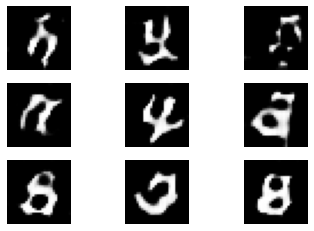

In [ ]:
#Evaluación
wgan.evaluate_D()
wgan.evaluate_G()

NOISED


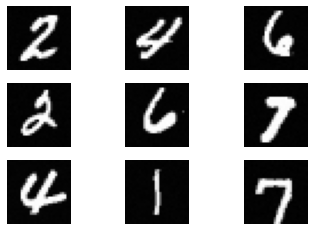

GENERATED


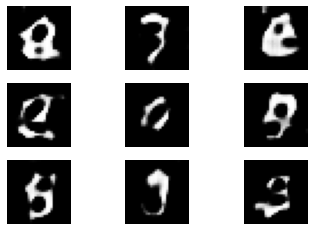

ORIGINAL


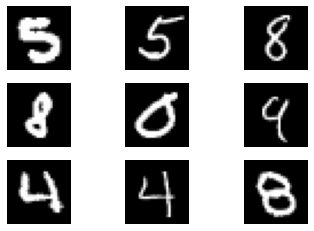

In [ ]:
#Veamos las imágenes generadas por el modelo generador que se ha definido para el EXPERIMENTO 1 y EXPERIMENTO 2
generated_images_plot(x_train, x_test, generator)

# EXPERIMENTO 3
Hemos cambiado la arquitectura del generador y del discriminador para que sea más sotisficada.  

*   En el discriminador se ha incluido más capas de Dropout y se ha utilizado las mejoras citadas en el experimento 2( incrementar dropout y reducir el learning rate). 
*   En el generador se ha implementado una arquitectura más profunda con más capas de convolución y añadiendo capas de BatchNormalization. 

In [ ]:
discriminator3=keras.Sequential(
    [
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(256, kernel_size=3, padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1),
    ],
    name="discriminator3"

)
discriminator3.summary()

Model: "discriminator3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 256)      

In [ ]:
generator3=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(28*28*128),
        layers.Reshape((28,28,128)),
        layers.Conv2D(32, kernel_size=3, padding="same",input_shape=(28,28,128)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator3",
)
generator3.summary()

Model: "generator3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100352)            12945408  
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        36896     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                              

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 1e-3,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

# Definimos el modelo WGAN.
wgan = WGAN(discriminator=discriminator3,
			generator=generator3,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Entrenamiento
wgan.fit(x_train, epochs=epochs, callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/75
8/8 [==============================] - 7s 60ms/step - d_loss: -7.6279 - g_loss: 3.1537 - _timestamp: 1652891060.0000 - _runtime: 11.0000
Epoch 2/75
8/8 [==============================] - 0s 44ms/step - d_loss: -4.6496 - g_loss: -3.8286 - _timestamp: 1652891060.0000 - _runtime: 11.0000
Epoch 3/75
8/8 [==============================] - 0s 46ms/step - d_loss: -3.1620 - g_loss: -3.5657 - _timestamp: 1652891061.0000 - _runtime: 12.0000
Epoch 4/75
8/8 [==============================] - 0s 46ms/step - d_loss: -2.7500 - g_loss: -1.7436 - _timestamp: 1652891061.0000 - _runtime: 12.0000
Epoch 5/75
8/8 [==============================] - 0s 45ms/step - d_loss: -2.2431 - g_loss: -1.5405 - _timestamp: 1652891061.0000 - _runtime: 12.0000
Epoch 6/75
8/8 [==============================] - 0s 46ms/step - d_loss: -2.1523 - g_loss: -0.6281 - _timestamp: 1652891062.0000 - _runtime: 13.0000
Epoch 7/75
8/8 [==============================] - 0s 45ms/step - d_loss: -1.9115 - g_loss: 0.3654 - _timest

d_loss,▁▄▅▅▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▅▇█▆▇█▇▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▁▁▃▂▅▃█▃▄▆▅▅▇█▇█▄▇▅▇▆▄▃▆▆▄▅▅▄▅▂▆▄▄▇█▄▆▄▄
d_loss,-1.28557
epoch,74
g_loss,1.47252


8/8 [==============================] - 0s 3ms/step - loss: -1.2022 - accuracy: 1.0000
>Accuracy real: 3%, fake: 100%
>Loss real: 
-1.7292641401290894
>Loss fake: 
-1.2022409439086914


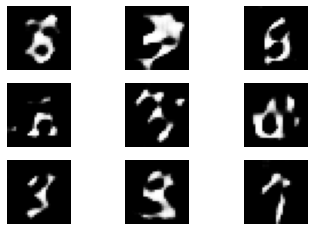

In [ ]:
#Evaluación
wgan.evaluate_D()
wgan.evaluate_G()

NOISED


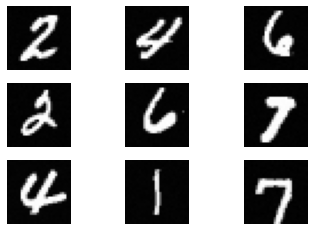

GENERATED


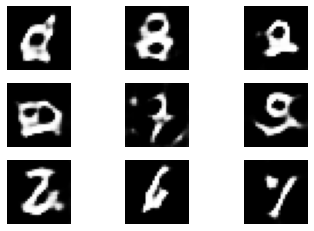

ORIGINAL


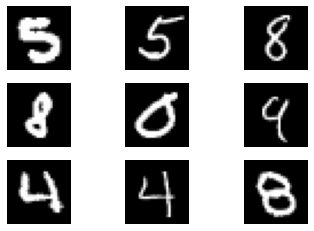

In [ ]:
#Veamos las imágenes generadas por el nuevo modelo generador que se ha definido para el EXPERIMENTO 3 
generated_images_plot(x_train, x_test, generator3)

# EXPERIMENTO 4
Vamos a definir nuestro modelo discriminador con una arquitectura que ya vienen preconfiguradas en Keras, llamada MobileNet. 

Esta arquitectura tiene como limitación que acepta imágenes de tamaño minimo 32x32,esto es, el parámetro input_shape de MobileNet no debe ser inferior a 32. Por tanto,tenemos que volver a leer nuestros datos y redimensionarlos de 28x28 a 32x32. 

El generador es un vesión adaptada del generador definido en Experimento 3, de forma que produce imágenes de tamaño 32x32x1

In [ ]:
################################################################################################################
## FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS Y  REDIMENSIONAR LAS IMAGENES A 32x32x1
###############################################################################################################

# La base de datos MNIST contiene 60000 ejemplos en el conjunto de entrenamiento y 10000 en el conjunto de prueba
# Las imagenes tienen un tamaño 28x28 que redimensionaremos a 32x32x1
def load_data_resize(): 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
   
    #Primero paso: Redimensiono las imagenes de 28x28 a 32x32
    ret=[]
    ret_test=[]
    for img in x_train:
      ret.append(resize(img,(32,32)))
    for img in x_test:
      ret_test.append(resize(img,(32,32)))

    x_train=np.asarray(ret)
    x_test=np.asarray(ret_test)

    #Segundo paso: Redimensiono las imagenes de 32x32 a 32x32x1
    x_train= x_train.reshape((60000, 32, 32, 1))
    x_test= x_test.reshape((10000, 32, 32, 1))
   
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
   
    #Añadir algo de ruido en el conjunto de prueba
    x_test = np.random.normal(x_test)  
   
    #Normalizamos a escala [0,1]
    x_train,x_test= x_train / 255,x_test / 255

    return (x_train, y_train), (x_test, y_test)

#Cargamos toda la base de datos MNIST redimensionada 
(x_train, y_train), (x_test, y_test) = load_data_resize()


In [ ]:
# Barajamos el conjunto de datos para no tener clases contiguas y nos quedamos con num_imagenes imágenes

# Declaramos una semilla
seed(123456)

# Guardamos índices
ind_train = list(range(len(x_train)))
ind_test = list(range(len(x_test)))

# Desordenamos los indices para quedarnos con num_imagenes imagenes aleatorias
shuffle(ind_train)
shuffle(ind_test)

# En base a los indices nos quedamos con num_imagenes imágenes
x_train            = x_train[ind_train[0:num_imagenes]]
y_train            = y_train[ind_train[0:num_imagenes]]

x_test             = x_test[ind_test[0:num_imagenes]]
y_test             = y_test[ind_test[0:num_imagenes]]

In [ ]:
discriminator4=tf.keras.applications.MobileNet(
    input_shape=(32,32,1), 
    alpha=1.0, 
    depth_multiplier=1,
    dropout=0.5, 
    include_top=False, 
    weights=None,  # Inicialización aleatoria de los pesos
    input_tensor=None, 
    pooling=None,
    classes=2,
    classifier_activation="sigmoid"
)
discriminator4.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                          

In [ ]:
generator4=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32*32*128),
        layers.Reshape((32,32,128)),
        layers.Conv2D(32, kernel_size=3, padding="same",input_shape=(32,32,128)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
        
    ],
    name="generator4",
)
generator4.summary()

Model: "generator4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        36896     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 32)       0         
 ePooling2D)                                            

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 1e-3,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

# Definimos el modelo WGAN.
wgan = WGAN(discriminator=discriminator4,
			generator=generator4,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Entrenamiento
wgan.fit(x_train, epochs=epochs, callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/75
8/8 [==============================] - 97s 414ms/step - d_loss: 114100962.8889 - g_loss: -0.3858 - _timestamp: 1652891265.0000 - _runtime: 103.0000
Epoch 2/75
8/8 [==============================] - 3s 378ms/step - d_loss: 249542711.3333 - g_loss: -0.4126 - _timestamp: 1652891268.0000 - _runtime: 106.0000
Epoch 3/75
8/8 [==============================] - 3s 383ms/step - d_loss: 102385561.4028 - g_loss: -0.4392 - _timestamp: 1652891271.0000 - _runtime: 109.0000
Epoch 4/75
8/8 [==============================] - 3s 377ms/step - d_loss: 111855108.5694 - g_loss: -0.4512 - _timestamp: 1652891274.0000 - _runtime: 112.0000
Epoch 5/75
8/8 [==============================] - 3s 371ms/step - d_loss: 125619929.1111 - g_loss: -0.4155 - _timestamp: 1652891277.0000 - _runtime: 115.0000
Epoch 6/75
8/8 [==============================] - 3s 373ms/step - d_loss: 34804772.9722 - g_loss: -0.4026 - _timestamp: 1652891280.0000 - _runtime: 118.0000
Epoch 7/75
8/8 [==============================] - 3s

d_loss,▁▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▄▂▁▃▃▂▂▄▃▅▅▅▅▄▆▆▅▅▆▆▆▆▇▆▆▆▇▆▆▇▇▇██▇█▇█▇▇
d_loss,8.7299
epoch,74
g_loss,-0.31388


8/8 [==============================] - 0s 9ms/step - loss: 0.2233 - accuracy: 0.0000e+00
>Accuracy real: 0%, fake: 0%
>Loss real: 
-0.7766861319541931
>Loss fake: 
0.2232809215784073


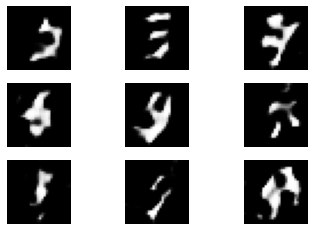

In [ ]:
#Evaluación
wgan.evaluate_D()
wgan.evaluate_G()